# MIE1624 Introduction to Data Science and Analytics

# Assignment 3: Sentiment Analysis

**Name: Jiani Jia**

**ID: 1002226245**

In [111]:
!pip install wordcloud

In [112]:
import pandas as pd
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from re import search
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings

## 1 Data Cleaning

In [113]:
sentiment_analysis_df = pd.read_csv('sentiment_analysis.csv')
sentiment_analysis_df

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [114]:
US_Elections_df = pd.read_csv('US_Elections_2020.csv')
US_Elections_df 

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19
3,b'Every 107 seconds an American is dying from ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN
...,...,...,...
2547,"b'RT @BoycottUtah: It is Friday, October 30, 2...",1,NaN
2548,b'@nowthisnews Delivered today in Montgomery C...,1,NaN
2549,b'@DonaldJTrumpJr DUHnnie Jr. lied on Fox when...,0,covid19
2550,b'RT @Pale_Ranger: Any ideas why @JoeBiden is ...,0,covid19


### 1.1 Remove all html tags and attributes (i.e., /<[^>]+>/)

In [115]:
# Using a regex, compile the regex pattern and match them into original text
def remove_html(text):
    html_remove = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(html_remove, '', text)
    return cleantext

In [116]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(remove_html)

In [117]:
US_Elections_df['text'] = US_Elections_df['text'].apply(remove_html)

### 1.2 Html character codes (i.e., &...;) are replaced with an ASCII equivalent

In [118]:
# Normal form form for the Unicode string
# NFKD will apply the compatibility decomposition, i.e. replace all compatibility characters with their equivalents
# Encode create creates a byte string, which cannot be mixed with a regular string
# Decode can convert back to string again
def ASCII_equivalent(text):
    ASCII_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return ASCII_text

In [119]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(ASCII_equivalent)

In [120]:
US_Elections_df['text'] = US_Elections_df['text'].apply(ASCII_equivalent)

### 1.3 Remove all URLs

In [121]:
def remove_URL(text):
    cleantext = re.sub(r'http\S+', '', text)
    return cleantext

In [122]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(remove_URL)

In [123]:
US_Elections_df['text'] = US_Elections_df['text'].apply(remove_URL)

In [124]:
sentiment_analysis_df['text'][11]

'Happy birthday to the most handsome kid in the world, love u like the son I never had congrats on the L @Snavitsky7 '

### 1.4 All characters in the text are in lowercase

In [125]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].str.lower()

In [126]:
US_Elections_df['text'] = US_Elections_df['text'].str.lower()

### 1.5 Remove all stop words

In [127]:
stop_word = pd.read_csv('stop_words.txt', names=['stop words'])

In [128]:
# Remove symbols in the words
def remove_non_letter(x):
    clean_text = re.sub(r'[^a-zA-Z ]+', ' ', x)
    return clean_text
#     return [re.sub(r'[^a-zA-Z ]+', ' ', str(x))]

In [129]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(remove_non_letter)

In [130]:
US_Elections_df['text'] = US_Elections_df['text'].apply(remove_non_letter)

In [131]:
# Remove inflectional endings and to return the base of a word (eg :s, ing)
nltk.download('wordnet')
def lemmatization(x):
    lemmatizer = nltk.WordNetLemmatizer()
    words_v = [lemmatizer.lemmatize(w, pos='v') for w in x.split()]
    words_n = [lemmatizer.lemmatize(w, pos='n') for w in words_v]
    return [lemmatizer.lemmatize(w, pos=('a')) for w in words_n]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [132]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(lemmatization)

In [133]:
US_Elections_df['text'] = US_Elections_df['text'].apply(lemmatization)

In [134]:
# Remove stop words from dataframe
# nltk.download('stopwords')
# stop_words = set(stopwords.words("english"))

def remove_stopword(x):
    return [word for word in x if word not in stop_word.values]

In [135]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(remove_stopword)

In [136]:
US_Elections_df['text'] = US_Elections_df['text'].apply(remove_stopword)

## 2 Exploratory analysis

### 2.1 Determines the political party from tweet

****
**Political Party in US include:**

1.Democratic Party: #BidenHarris2020, #Biden, #JoeBiden, #Democrats, #DiversityandInclusion, @JoeBiden, #VOTEBLUE, #bidenharria, #BidenCrimeFamily, #ChinaJoe

2.Republican Party: @realDonaldTrump, @#DonaldTrump, #MAGA, @GOP, @EricTrump, @DonaldJTrumpJr, #BuildTheWall, #RedWaveRising2020, @IvankaTrump, #VoteRed, #RedWave, #Trump2020, @Mike_Pence, @TeamTrump, #TrumpCrimeFamily, #TrumpVirus, #Republican, #VoteTrumpOut, #VoteHimOut, #TrumpLiesAmericansDie

3.Others

****

In [137]:
# Keyword for two Parties
democratic = ['biden', 'democrats', 'diversityandinclusion', 'voteblue', 'chinajoe']
republican = ['trump', 'buildthewall', 'votered', 'redwave', 'republican', 'maga']
US_Elections_df['party'] = 'NaN'
democratic_list = []
republican_list = []
democratic_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
republican_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
other_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])

for i in range(US_Elections_df.shape[0]):
    democratic_list = []
    republican_list = []
    election_list = US_Elections_df['text'][i]

    for d in democratic:
        for s in election_list:
            if d in s:
                democratic_list.append(s)
    for r in republican:
        for s in election_list:
             if r in s:
                republican_list.append(s)
                        
    if len(democratic_list) > len(republican_list):
        democratic_df = democratic_df.append(US_Elections_df.iloc[i], ignore_index=True)
        US_Elections_df['party'][i] = 'Democratic'
    elif len(democratic_list) < len(republican_list):
        republican_df = republican_df.append(US_Elections_df.iloc[i], ignore_index=True)
        US_Elections_df['party'][i] = 'Republican'
    elif len(democratic_list) == len(republican_list):
        other_df = other_df.append(US_Elections_df.iloc[i], ignore_index=True) 
        US_Elections_df['party'][i] = 'Other'

In [138]:
print('Democratic Party has {:.2%}'.format(democratic_df.shape[0]/US_Elections_df.shape[0]),'tweets')

Democratic Party has 20.65% tweets


In [139]:
print('Republican Party has {:.2%}'.format(republican_df.shape[0]/US_Elections_df.shape[0]) ,'tweets')

Republican Party has 29.19% tweets


In [140]:
print('Other contains {:.2%}'.format(other_df.shape[0]/US_Elections_df.shape[0]) ,'tweets')

Other contains 50.16% tweets


****
**Description:**

Choosing the simplest key words for both democratic party and republican party. The related words can be found by partial word in the key word list, like 'biden' is in the keyword list, it is able to find all words that contain 'biden', include 'joebiden' ,'bidenharris2020', etc.

In one tweet, if there are more democratic party key words than republican party key words, it can be determine as a  democratic party relevant tweet. If  more republican party key words than democratic party key words, it is a republican party relevant tweet. Otherwise, this tweet determines as 'Other'.

As result, among 2552 tweets, 20.65% tweets are about Democratic Party, 29.19% tweets are about Republican Party, and other contains 50.16% tweets.

****

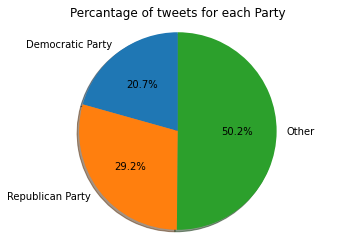

In [141]:
labels = 'Democratic Party', 'Republican Party', 'Other'
sizes = [democratic_df.shape[0]/US_Elections_df.shape[0], republican_df.shape[0]/US_Elections_df.shape[0], 
         other_df.shape[0]/US_Elections_df.shape[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Percantage of tweets for each Party')
plt.show()

****
**What can you say about the distribution of the political affiliations of the tweets?**

From above pie chart and analyzed data, approximately half of the tweets are associated with the US election, talking about the two candidate parties. Over half of the tweets are talking about Republican party, which is related to Trump.

****

### 2.2 Graphical figure

#### 2.2.1 Graph for sentiment_analysis.csv

In [142]:
positive_tweet_df = sentiment_analysis_df.loc[sentiment_analysis_df['label'] == 1]
negative_tweet_df = sentiment_analysis_df.loc[sentiment_analysis_df['label'] == 0]
positive_tweet_count = positive_tweet_df.shape[0]
negative_tweet_count = negative_tweet_df.shape[0]

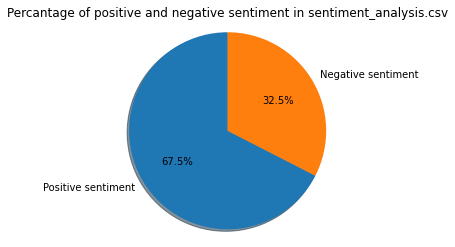

In [143]:
labels = ['Positive sentiment', 'Negative sentiment']
sizes = [positive_tweet_count, negative_tweet_count]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percantage of positive and negative sentiment in sentiment_analysis.csv')
plt.show()

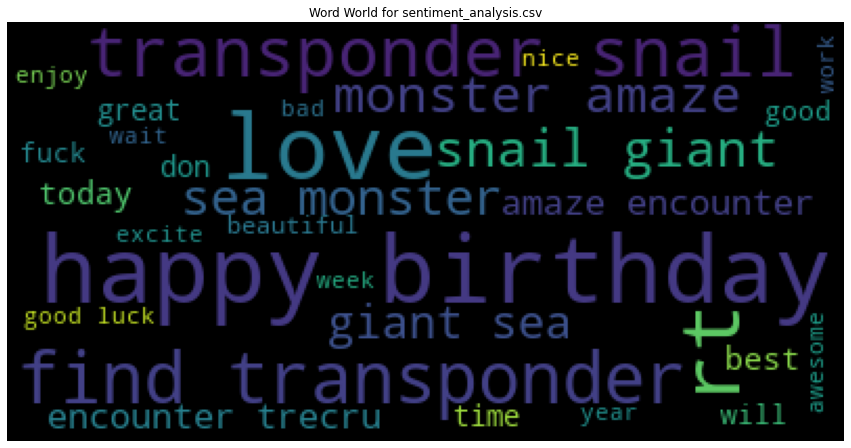

In [144]:
# Plot word world for sentiment_analysis.csv
def join_str(x):
    return " ".join(x)
single_string = sentiment_analysis_df['text'].apply(join_str)
comment_words = " ".join(single_string)
wordcloud = WordCloud(min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.title('Word World for sentiment_analysis.csv')
plt.show()

****
**1. Pie chart shows that in sentiment_analysis.csv, among 550391 tweets, there are 67.5% tweets are positve sentiment and 32.5% tweets are negative sentiment.**

**2. Through the second wordcloud chart, the key word in the sentiment_analysis.csv can be visualized.**

****

#### 2.2.2 Graph for US_Elections_2020.csv

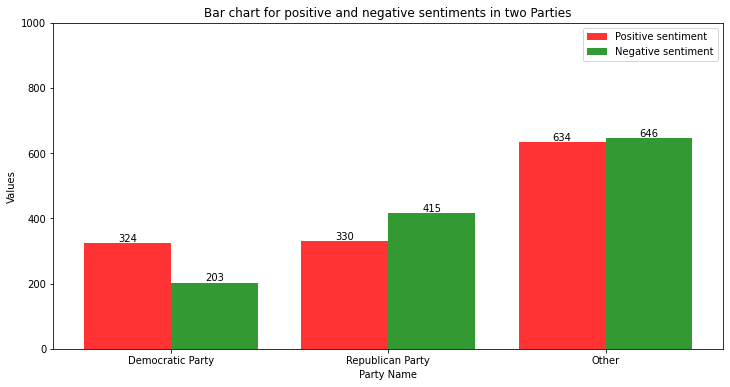

In [145]:
plt.figure(figsize=(12,6))
name = ['Democratic Party', 'Republican Party', 'Other']  
positive_democratic_df = democratic_df.loc[democratic_df['sentiment'] == 1]
negative_democratic_df = democratic_df.loc[democratic_df['sentiment'] == 0]

positive_republican_df = republican_df.loc[republican_df['sentiment'] == 1]
negative_republican_df = republican_df.loc[republican_df['sentiment'] == 0]

positive_other_df = other_df.loc[other_df['sentiment'] == 1]
negative_other_df = other_df.loc[other_df['sentiment'] == 0]

value1 = [positive_democratic_df.shape[0], positive_republican_df.shape[0], positive_other_df.shape[0]]
value2 = [negative_democratic_df.shape[0], negative_republican_df.shape[0], negative_other_df.shape[0]]
x = range(3)
bar1 = plt.bar(x = [i - 0.2 for i in x], height = value1, width = 0.4,
               alpha = 0.8, color = 'r',label = 'Positive sentiment')                  

bar2 = plt.bar([i + 0.2 for i in x], value2, width = 0.4,
               alpha = 0.8,color = 'g',label = 'Negative sentiment')                  
plt.xticks(x,name)     
plt.ylim(0,1000)      
plt.title('Bar chart for positive and negative sentiments in two Parties')    
plt.xlabel('Party Name')    
plt.ylabel('Values')      
plt.legend() 

def label(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '{}'.format(height),
                ha='center', va='bottom')

label(bar1)
label(bar2)
plt.show()

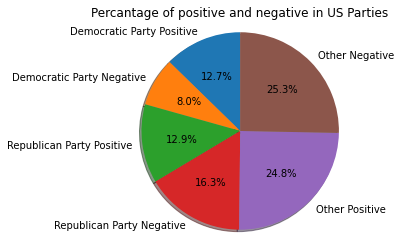

In [146]:
labels = ['Democratic Party Positive', 'Democratic Party Negative', 
          'Republican Party Positive', 'Republican Party Negative',
          'Other Positive', 'Other Negative']
sizes = [positive_democratic_df.shape[0]/US_Elections_df.shape[0], negative_democratic_df.shape[0]/US_Elections_df.shape[0],
         positive_republican_df.shape[0]/US_Elections_df.shape[0], negative_republican_df.shape[0]/US_Elections_df.shape[0],
         positive_other_df.shape[0]/US_Elections_df.shape[0], negative_other_df.shape[0]/US_Elections_df.shape[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percantage of positive and negative in US Parties')
plt.show()

****
**For Democratic party, the related positive sentiment tweets are more than negative sentiment tweets. And for Republican party, the related  negative sentiment tweets are more than positive sentiment tweets.**

****

## 3 Model Preparation

### 3.1 Two different types of features

In [147]:
# Transfer each row in dataframe to string
def join_str(x):
    return " ".join(x)
single_string = sentiment_analysis_df['text'].apply(join_str)

#### 3.1.1 Bag of Words (word frequency)

In [148]:
def bag_of_words(textdata):
    CountVec = CountVectorizer()
    Count_data = CountVec.fit_transform(textdata)
    feature_name = CountVec.get_feature_names()
#     cv_dataframe = pd.DataFrame(Count_data.T.toarray(), index=CountVec.get_feature_names(), columns=["Word Frequency"])
#     cv_dataframe = cv_dataframe.sort_values('Word Frequency', ascending=False)
    return Count_data

In [149]:
bag_of_words_X = bag_of_words(single_string)
bag_of_words_X

<550391x317251 sparse matrix of type '<class 'numpy.int64'>'
	with 3510458 stored elements in Compressed Sparse Row format>

****
**Limitation of bag of words:**

1.The model ignores the location information of the word.

2.Bag of word models doesn’t respect the semantics of the word.

3.The range of vocabulary is a big issue faced by the Bag-of-Words model.

****

#### 3.1.2 TF-IDF

In [150]:
# Calculate TF-IDF score and return them in order
def tf_idf(textdata):
    tfIdfVectorizer = TfidfVectorizer()
    tfIdf = tfIdfVectorizer.fit_transform(textdata)
#     tfIdf_df = pd.DataFrame(tfIdf[0].T.toarray(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
#     tfIdf_df = tfIdf_df.sort_values('TF-IDF', ascending=False)
    return tfIdf

In [151]:
tfIdf_X = tf_idf(single_string)
tfIdf_X

<550391x317251 sparse matrix of type '<class 'numpy.float64'>'
	with 3510458 stored elements in Compressed Sparse Row format>

****
**The highest ranking words in terms of TF-IDF score can represent the keywords of that document, which means apply TF-IDF, we can very easily sort the TF-IDF score to extract the keywords from a text.**

****

### 3.2 Split training data and test data

In [152]:
Y_data = sentiment_analysis_df['label']

In [153]:
BW_x_train, BW_x_test, BW_y_train, BW_y_test = train_test_split(bag_of_words_X, Y_data, test_size = 0.30, random_state = 42)
TfIdf_x_train, TfIdf_x_test, TfIdf_y_train, TfIdf_y_test = train_test_split(tfIdf_X, Y_data, test_size = 0.30, random_state = 42)
print('Training set has shape',BW_x_train.shape, 'and test set has shape', BW_x_test.shape)
print('Training set has shape',np.array(BW_y_train).reshape(-1,1).shape, 'and test set has shape', np.array(BW_y_test).reshape(-1,1).shape)

Training set has shape (385273, 317251) and test set has shape (165118, 317251)
Training set has shape (385273, 1) and test set has shape (165118, 1)


## 4 Model implementation and tuning

### 4.1 Train models on the training data

#### 4.1.1 Logistic regression

In [58]:
warnings.filterwarnings("ignore")

In [154]:
# Grid search
def grid_serach(parameters, model, X, Y):
    parameters = parameters
    grid_obj = GridSearchCV(model, parameters, scoring='accuracy')
    grid_obj = grid_obj.fit(X, Y)
    best_hyper = grid_obj.best_params_
    best_est = grid_obj.best_estimator_
    return best_hyper, best_est

In [60]:
# Grid search for logistic regression bag of words
best_hyper_BW_LG, best_est_BW_LG = grid_serach({'C': np.arange(0,3,1)}, 
                                               LogisticRegression(), BW_x_train, BW_y_train)

In [61]:
print('Best hyparparameter for logistic regression bag of words', best_hyper_BW_LG)
print('Best model for logistic regression bag of words', best_est_BW_LG)

Best hyparparameter for logistic regression bag of words {'C': 2}
Best model for logistic regression bag of words LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [65]:
# Bag of word
model_BW_LG = best_est_BW_LG
model_BW_LG.fit(BW_x_train, BW_y_train)
prediction_BW_LG = model_BW_LG.predict(BW_x_test)
accuracy_BW_LG = accuracy_score(BW_y_test, prediction_BW_LG)

In [73]:
print ('Accuracy for Bag of word in test set using Logistic Regression:', accuracy_BW_LG)

Accuracy for Bag of word in test set using Logistic Regression: 0.9580663525478749


In [155]:
# Grid search for logistic regression TF-IDF
best_hyper_TfIdf_LG, best_est_TfIdf_LG = grid_serach({'C': np.arange(0,3,1)}, 
                                                     LogisticRegression(), TfIdf_x_train, TfIdf_y_train)

In [156]:
print('Best hyparparameter for logistic regression TF-IDF', best_hyper_TfIdf_LG)
print('Best model for logistic regression TF-IDF', best_est_TfIdf_LG)

Best hyparparameter for logistic regression TF-IDF {'C': 2}
Best model for logistic regression TF-IDF LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [157]:
# TF-IDF
model_TfIdf_LG = best_est_TfIdf_LG
model_TfIdf_LG.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_LG = model_TfIdf_LG.predict(TfIdf_x_test)
accuracy_TfIdf_LG = accuracy_score(TfIdf_y_test, prediction_TfIdf_LG)

In [ ]:
print ('Accuracy for TF-IDF in test set using Logistic Regression:', accuracy_TfIdf_LG)

Accuracy for TF-IDF in test set using Logistic Regression: 0.9588839496602429


 #### 4.1.2 Decision trees

In [ ]:
# Bag of word
DT_BW = DecisionTreeClassifier()
DT_BW = DT_BW.fit(BW_x_train, BW_y_train)
prediction_BW_DT = DT_BW.predict(BW_x_test)
accuracy_BW_DT = accuracy_score(BW_y_test, prediction_BW_DT)

In [ ]:
print ('Accuracy for Bag of word in test set using Decision Trees:', accuracy_BW_DT)

Accuracy for Bag of word in test set using Decision Trees: 0.9319335263266271


In [ ]:
# TF-IDF
DT_TfIdf = DecisionTreeClassifier()
DT_TfIdf = DT_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_DT = DT_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_DT = accuracy_score(TfIdf_y_test, prediction_TfIdf_DT)

In [ ]:
print ('Accuracy for TF-IDF in test set using Decision Trees:', accuracy_TfIdf_DT)

Accuracy for TF-IDF in test set using Decision Trees: 0.9292990467423298


#### 4.1.3 k-NN

In [ ]:
# Bag of word
knn_BW = KNeighborsClassifier()
knn_BW = knn_BW.fit(BW_x_train, BW_y_train)
prediction_BW_knn = knn_BW.predict(BW_x_test)
accuracy_BW_knn = accuracy_score(BW_y_test, prediction_BW_knn)

In [ ]:
print ('Accuracy for Bag of word in test set using K-NN:', accuracy_BW_knn)

Accuracy for Bag of word in test set using K-NN: 0.8998655506970772


In [ ]:
# TF-IDF
knn_TfIdf = KNeighborsClassifier()
knn_TfIdf = knn_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_knn = knn_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_knn = accuracy_score(TfIdf_y_test, prediction_TfIdf_knn)

In [ ]:
print ('Accuracy for TF-IDF in test set using K-NN:', accuracy_TfIdf_knn)

Accuracy for TF-IDF in test set using K-NN: 0.621519155997529


#### 4.1.4 Naive Bayes

****
**Note: MultinomialNB implements the naive Bayes algorithm for multinomially distributed data. It is one of the two classic naive Bayes variants used in text classification**

****

In [ ]:
# Grid search for Naive Bayes bag of words
best_hyper_NB_BW, best_est_NB_BW = grid_serach({'alpha':np.arange(0,1,0.1)}, 
                                               MultinomialNB(), BW_x_train, BW_y_train)

In [ ]:
print('Best hyparparameter for Naive Bayes bag of words', best_hyper_NB_BW)
print('Best model for Naive Bayes bag of words', best_est_NB_BW)

Best hyparparameter for Naive Bayes bag of words {'alpha': 0.9}
Best model for Naive Bayes bag of words MultinomialNB(alpha=0.9, class_prior=None, fit_prior=True)


In [ ]:
# Bag of word
NB_BW = MultinomialNB(alpha=0.9, class_prior=None, fit_prior=True)
NB_BW = NB_BW.fit(BW_x_train, BW_y_train)
prediction_BW_NB = NB_BW.predict(BW_x_test)
accuracy_BW_NB = accuracy_score(BW_y_test, prediction_BW_NB)

In [ ]:
print ('Accuracy for Bag of word in test set using Naive Bayes:', accuracy_BW_NB)

Accuracy for Bag of word in test set using Naive Bayes: 0.9319093012270013


In [ ]:
# Grid search for Naive Bayes TF-IDF
best_hyper_TfIdf_BW, best_est_TfIdf_BW = grid_serach({'alpha':np.arange(0,1,0.1)}, 
                                                     MultinomialNB(), TfIdf_x_train, TfIdf_y_train)

In [ ]:
print('Best hyparparameter for Naive Bayes TF-IDF', best_hyper_TfIdf_BW)
print('Best model for Naive Bayes TF-IDF', best_est_TfIdf_BW)

Best hyparparameter for Naive Bayes TF-IDF {'alpha': 0.30000000000000004}
Best model for Naive Bayes TF-IDF MultinomialNB(alpha=0.30000000000000004, class_prior=None, fit_prior=True)


In [ ]:
# TF-IDF
NB_TfIdf = MultinomialNB(alpha=0.3, class_prior=None, fit_prior=True)
NB_TfIdf = NB_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_NB = NB_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_NB = accuracy_score(TfIdf_y_test, prediction_TfIdf_NB)

In [ ]:
print ('Accuracy for TF-IDF in test set using Naive Bayes:', accuracy_TfIdf_NB)

Accuracy for TF-IDF in test set using Naive Bayes: 0.9111726159473831


#### 4.1.5 SVM

****
**Noet: linearSVC is similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples. Since our dataset has more than 550,000 features, linearSVC is more suitablt to our situation.**

****

In [ ]:
# Grid search for SVM bag of words
best_hyper_SVM_BW, best_est_SVM_BW = grid_serach({'penalty': ['l1', 'l2'], 'loss':['hinge', 'squared_hinge']}, 
                                                   LinearSVC(), BW_x_train, BW_y_train)

In [ ]:
print('Best hyparparameter for SVM bag of words', best_hyper_SVM_BW)
print('Best model for SVM bag of words', best_est_SVM_BW)

Best hyparparameter for SVM bag of words {'loss': 'hinge', 'penalty': 'l2'}
Best model for SVM bag of words LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [ ]:
# Bag of word
SVM_BW = LinearSVC(C=1.0, loss='hinge', penalty='l2')
SVM_BW = SVM_BW.fit(BW_x_train, BW_y_train)
prediction_BW_SVM = SVM_BW.predict(BW_x_test)
accuracy_BW_SVM = accuracy_score(BW_y_test, prediction_BW_SVM)

In [ ]:
print ('Accuracy for Bag of word in test set using SVM:', accuracy_BW_SVM)

Accuracy for Bag of word in test set using SVM: 0.955607504935864


In [ ]:
# Grid search for SVM TF-IDF
best_hyper_SVM_TfIdf, best_est_SVM_TfIdf = grid_serach({'penalty': ['l1', 'l2'], 'loss':['hinge', 'squared_hinge']}, 
                                                   LinearSVC(), TfIdf_x_train, TfIdf_y_train)

In [ ]:
print('Best hyparparameter for SVM TF-IDF', best_hyper_SVM_TfIdf)
print('Best model for SVM TF-IDF', best_est_SVM_TfIdf)

Best hyparparameter for SVM TF-IDF {'loss': 'hinge', 'penalty': 'l2'}
Best model for SVM TF-IDF LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [ ]:
# TF-IDF
SVM_TfIdf = LinearSVC(C=1.0, loss='hinge', penalty='l2')
SVM_TfIdf = SVM_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_SVM = SVM_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_SVM = accuracy_score(TfIdf_y_test, prediction_TfIdf_SVM)

In [ ]:
print ('Accuracy for TF-IDF in test set using SVM:', accuracy_TfIdf_SVM)

Accuracy for TF-IDF in test set using SVM: 0.9584115602175414


#### 4.1.6 Random forest

In [ ]:
# Bag of word
RF_BW = RandomForestClassifier(n_estimators=10)
RF_BW = RF_BW.fit(BW_x_train, BW_y_train)
prediction_BW_RF = RF_BW.predict(BW_x_test)
accuracy_BW_RF = accuracy_score(BW_y_test, prediction_BW_RF)

In [ ]:
print ('Accuracy for Bag of word in test set using Random Forest:', accuracy_BW_RF)

Accuracy for Bag of word in test set using Random Forest: 0.9399883719521797


In [ ]:
# TF-IDF
RF_TfIdf = RandomForestClassifier(n_estimators=10)
RF_TfIdf = RF_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_RF = RF_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_RF = accuracy_score(TfIdf_y_test, prediction_TfIdf_RF)

In [ ]:
print ('Accuracy for TF-IDF in test set using Random Forest:', accuracy_TfIdf_RF)

Accuracy for TF-IDF in test set using Random Forest: 0.942174687193401


#### 4.1.7 XGBoost

In [ ]:
XGB_BW = xgb.XGBClassifier()
XGB_BW = XGB_BW.fit(BW_x_train, BW_y_train)
prediction_BW_XGB = XGB_BW.predict(BW_x_test)
accuracy_BW_XGB = accuracy_score(BW_y_test, prediction_BW_XGB)

In [ ]:
print ('Accuracy for Bag of word in test set using XGBoost:', accuracy_BW_XGB)

Accuracy for Bag of word in test set using XGBoost: 0.8419615063166948


In [ ]:
XGB_TfIdf = xgb.XGBClassifier()
XGB_TfIdf = XGB_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_XGB = XGB_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_XGB = accuracy_score(TfIdf_y_test, prediction_TfIdf_XGB)

In [ ]:
print ('Accuracy for TF-IDF in test set using XGBoost:', accuracy_TfIdf_XGB)

Accuracy for TF-IDF in test set using XGBoost: 0.8426276965564021


### 4.2 Best model performance on the 2020 US elections data

**Result Table**

| Feature |Logistic Regression | Decision trees | k-NN | Naive Bayes | SVM | Random Forest | XGBoost |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Bag of Words | 0.95807 | 0.931933 | 0.89986 | 0.93191 | 0.955607 | 0.93999 | 0.84196 |
| TF-IDF | 0.95888 | 0.92929 | 0.62151 | 0.91117 | 0.95841| 0.94217 | 0.84263 |

**Conclusion: best model is Logistic regression for TF-IDF feature.**

In [158]:
# Tranform the US election to same feature size as generic data
single_string_US = US_Elections_df['text'].apply(join_str)
tfIdfVectorizer = TfidfVectorizer()
tfIdfVectorizer.fit(single_string)
tfIdf_X_US = tfIdfVectorizer.transform(single_string_US)
tfIdf_X_US

<2552x317251 sparse matrix of type '<class 'numpy.float64'>'
	with 17545 stored elements in Compressed Sparse Row format>

In [159]:
y_us = US_Elections_df['sentiment']
prediction_us = model_TfIdf_LG.predict(tfIdf_X_US)
accuracy_us = accuracy_score(y_us, prediction_us)
print('The best performance on the 2020 US elections data has accuracy', accuracy_us)

The best performance on the 2020 US elections data has accuracy 0.7127742946708464


****
**How well do your predictions match the sentiment labelled in the 2020 US elections data?**

In this part, we test the best model that selected from the last part at the 2020 US election data. The result accuracy is 71.28%, which has the worse performance compared with the generic data. 

Although the prediction of amount of positive and negative sentiments are disparity with the true value. The prediction for Republican party has the same trend with the true sentiment, the negative sentiments are more than the positive sentiments. For Democratic party, the prediction shows that more negative sentiment than the positive, but the true situtation has the opposite trend with it. The amount of predictive negative are always higher than the actual amount, and the predictive positive are always lower then actual.

****

#### 4.2.1 Visualize sentiment prediction results and true sentiment

In [160]:
US_Elections_df['predict'] = prediction_us

In [161]:
# Original positive for Democratic 
pos_org_dem = US_Elections_df.loc[US_Elections_df['sentiment'] == 1][US_Elections_df['party'] == 'Democratic'].shape[0]
# Original negative for Democratic 
neg_org_dem = US_Elections_df.loc[US_Elections_df['sentiment'] == 0][US_Elections_df['party'] == 'Democratic'].shape[0]
# Predict positive for Democratic 
pos_pred_dem = US_Elections_df.loc[US_Elections_df['predict'] == 1][US_Elections_df['party'] == 'Democratic'].shape[0]
# Predict negative for Democratic 
neg_pred_dem = US_Elections_df.loc[US_Elections_df['predict'] == 0][US_Elections_df['party'] == 'Democratic'].shape[0]

# Original postive for Republican
pos_org_rep = US_Elections_df.loc[US_Elections_df['sentiment'] == 1][US_Elections_df['party'] == 'Republican'].shape[0]
# Original negative for Republican
neg_org_rep = US_Elections_df.loc[US_Elections_df['sentiment'] == 0][US_Elections_df['party'] == 'Republican'].shape[0]
# Predict positive for Republican 
pos_pred_rep = US_Elections_df.loc[US_Elections_df['predict'] == 1][US_Elections_df['party'] == 'Republican'].shape[0]
# Predict negative for Republican 
neg_pred_rep = US_Elections_df.loc[US_Elections_df['predict'] == 0][US_Elections_df['party'] == 'Republican'].shape[0]

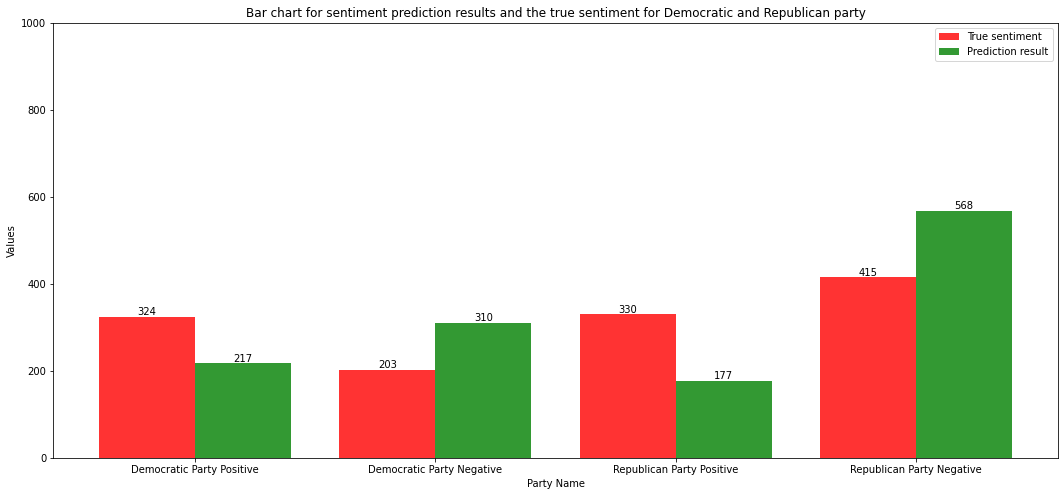

In [162]:
plt.figure(figsize=(18,8))
name = ['Democratic Party Positive', 'Democratic Party Negative', 'Republican Party Positive', 'Republican Party Negative']  

value1 = [pos_org_dem, neg_org_dem, pos_org_rep, neg_org_rep]
value2 = [pos_pred_dem, neg_pred_dem, pos_pred_rep, neg_pred_rep]

X = np.arange(4) 
bar1 = plt.bar(x = [i - 0.2 for i in X], height=value1, width=0.4,
               alpha=0.8, color='r',label ='True sentiment')                  

bar2 = plt.bar([i + 0.2 for i in X], height=value2, width = 0.4,
               alpha=0.8,color ='g', label ='Prediction result')  
 
plt.xticks(X, name)     
plt.ylim(0,1000)     
plt.title('Bar chart for sentiment prediction results and the true sentiment for Democratic and Republican party')    
plt.xlabel('Party Name')    
plt.ylabel('Values')      
plt.legend()

def label(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '{}'.format(height),
                ha='center', va='bottom')

label(bar1)
label(bar2)
plt.show()

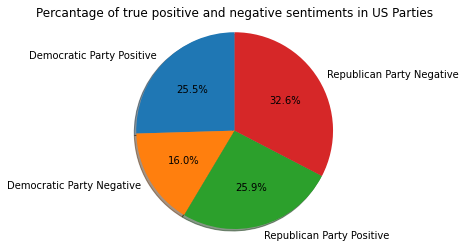

In [163]:
labels = ['Democratic Party Positive', 'Democratic Party Negative', 
          'Republican Party Positive', 'Republican Party Negative']
sizes = [pos_org_dem, neg_org_dem, pos_org_rep, neg_org_rep]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Percantage of true positive and negative sentiments in US Parties')
plt.show()

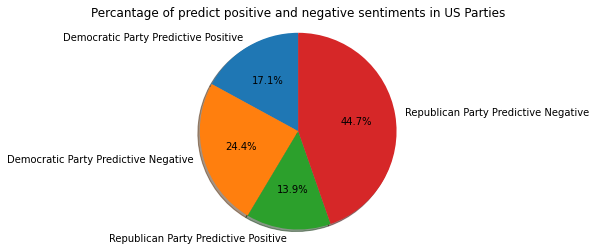

In [164]:
labels = ['Democratic Party Predictive Positive', 'Democratic Party Predictive Negative', 
          'Republican Party Predictive Positive', 'Republican Party Predictive Negative']
sizes = [pos_pred_dem, neg_pred_dem, pos_pred_rep, neg_pred_rep]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Percantage of predict positive and negative sentiments in US Parties')
plt.show()

****
**Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.**

The NLP analytics determines the sentiments of public and understanding the public opinion for the candidates. It is helpful to predict which candiates can win the election. From the result, the amount of positive tweets for both Parties are similar, and the negative sentiments for Republican party are occuped a larger part. 

From the 2020 US election result, Joe Biden got 306 electoral votes and Donald Trump got 232 electoral votes. NLP analytics based on tweets is useful for political parties during election campaigns, it shows that Trump has more negative sentiment on tweet.

****

In [165]:
neg_US_df = US_Elections_df.loc[US_Elections_df['sentiment'] == 0]
print('Numner of Null in negative_reason column is', neg_US_df['negative_reason'].isnull().sum())

Numner of Null in negative_reason column is 0


In [166]:
reason_list = neg_US_df['negative_reason'].unique()
reason_list

array(['covid19', 'others', 'discrimination', 'corruption', 'crime'],
      dtype=object)

In [167]:
reason_encode = {
    'covid19': 0,
    'others': 1, 
    'discrimination': 2, 
    'corruption': 3, 
    'crime':4
}

In [168]:
neg_US_df['negative_reason'] = neg_US_df['negative_reason'].map(reason_encode)
neg_US_df

,text,sentiment,negative_reason,party,predict
0,"[robreiner, afraid, nov, dec, jan, bidenharris...",0,0,Democratic,0
1,"[rt, suec, lord, sumption, launch, recovery, i...",0,1,Other,1
2,"[rt, walidphares, uber, time, biden, advisor, ...",0,0,Democratic,0
5,"[accelerate, rise, american, kill, trumpvirus]",0,2,Republican,0
6,"[realdonaldtrump, dead, american, day, time, n...",0,2,Republican,0
...,...,...,...,...,...
2542,"[love, air, watch, watch, news, hate, brainwas...",0,4,Other,0
2543,"[rt, euinaus, challenge, humanity, year, covid...",0,2,Other,0
2544,"[ty, flip, dump, day, year, day, resist, maga,...",0,0,Republican,1
2549,"[donaldjtrumpjr, duhnnie, jr, lie, fox, number...",0,0,Republican,0


In [186]:
neg_us_string = neg_US_df['text'].apply(join_str)
BoW_neg_X = bag_of_words(neg_us_string)
BoW_neg_X

<1264x3721 sparse matrix of type '<class 'numpy.int64'>'
	with 10923 stored elements in Compressed Sparse Row format>

In [187]:
TfIdf_neg_X = tf_idf(neg_us_string)
TfIdf_neg_X

<1264x3721 sparse matrix of type '<class 'numpy.float64'>'
	with 10923 stored elements in Compressed Sparse Row format>

In [210]:
y_us = neg_US_df['negative_reason']
# Bag of words
BoW_neg_x_train, BoW_neg_x_test, BoW_neg_y_train, BoW_neg_y_test = train_test_split(BoW_neg_X, y_us, test_size = 0.30, random_state = 42)
# TF-IDF
TfIdf_neg_x_train, TfIdf_neg_x_test, TfIdf_neg_y_train, TfIdf_neg_y_test = train_test_split(TfIdf_neg_X, y_us, test_size = 0.30, random_state = 42)

#### 4.2.1 Logistic regression 

In [81]:
# Bag of words
best_hyper_LRBoW, best_est_LRBoW = grid_serach({'C': np.arange(0, 3, 0.5), 
              'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'saga']},
               LogisticRegression(), BoW_neg_x_train, BoW_neg_y_train)

In [82]:
best_est_LRBoW

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
LRBoW_model = best_est_LRBoW
kfold = KFold(n_splits=5)
accuracy_LRBoW_model_train = cross_val_score(LRBoW_model, BoW_neg_x_train, BoW_neg_y_train, cv=kfold)
print('Train accuracy for Logistic Regression bag of words', np.mean(accuracy_LRBoW_model_train))
# LRBoW_model = LRBoW_model.fit(BoW_neg_x_train, BoW_neg_y_train)
# prediction_LRBoW_model_test = LRBoW_model.predict(BoW_neg_x_test)
# accuracy_LRBoW_model_test = accuracy_score(BoW_neg_y_test, prediction_LRBoW_model_test)
# print('Test accuracy for Logistic Regression bag of words', accuracy_LRBoW_model_test)

Train accuracy for Logistic Regression bag of words 0.33825757575757576


In [86]:
# TF-IDF
best_hyper_LRTfIdf, best_est_LRTfIdf = grid_serach({'C': np.arange(0, 3, 0.5), 
              'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'saga']}, 
              LogisticRegression(), TfIdf_neg_x_train, TfIdf_neg_y_train)

In [87]:
best_est_LRTfIdf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [95]:
LRTfIdf_model = best_est_LRTfIdf
kfold = KFold(n_splits=5)
accuracy_LRTfIdf_model_train = cross_val_score(LRTfIdf_model, TfIdf_neg_x_train, TfIdf_neg_y_train, cv=kfold)
print('Train accuracy for Logistic Regression TF-IDF', np.mean(accuracy_LRTfIdf_model_train))

# LRTfIdf_model = LRTfIdf_model.fit(TfIdf_neg_x_train, TfIdf_neg_y_train)
# prediction_LRTfIdf_model_test = LRTfIdf_model.predict(TfIdf_neg_x_test)
# accuracy_LRTfIdf_model_test = accuracy_score(TfIdf_neg_y_test, prediction_LRTfIdf_model_test)
# print('Accuracy for Logistic Regression TF-IDF', accuracy_LRTfIdf_model_test)

Train accuracy for Logistic Regression TF-IDF 0.352914740626605


#### 4.2.2 SVM

In [91]:
# Bag of words
best_hyper_SVMBoW, best_est_SVMBoW = grid_serach({'penalty': ['l1','l2'], 'loss': ['hinge','squared_hinge'],
                                               'C':np.arange(0, 3, 0.5)}, 
                                                LinearSVC(), BoW_neg_x_train, BoW_neg_y_train)

In [92]:
best_est_SVMBoW

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [94]:
SVMBoW_model = best_est_SVMBoW
kfold = KFold(n_splits=5)
accuracy_SVMBoW_model_train = cross_val_score(SVMBoW_model, BoW_neg_x_train, BoW_neg_y_train, cv=kfold)
SVMBoW_model = SVMBoW_model.fit(BoW_neg_x_train, BoW_neg_y_train)
print('Train accuracy for SVM bag of words', np.mean(accuracy_SVMBoW_model_train))

# SVMBoW_model = SVMBoW_model.fit(BoW_neg_x_train, BoW_neg_y_train)                                           
# prediction_SVMBoW_model_test = SVMBoW_model.predict(BoW_neg_x_test)
# accuracy_SVMBoW_model_test = accuracy_score(BoW_neg_y_test, prediction_SVMBoW_model_test)
# print('Accuracy for SVM bag of words', accuracy_SVMBoW_model_test)

Train accuracy for SVM bag of words 0.29752182845403186


In [98]:
# TF-IDF
best_hyper_SVMTfIdf, best_est_SVMTfIdf = grid_serach({'penalty': ['l1','l2'], 'loss': ['hinge','squared_hinge'],
                                               'C':np.arange(0, 3, 0.5)}, 
                                                LinearSVC(), TfIdf_neg_x_train, TfIdf_neg_y_train)

In [99]:
best_est_SVMTfIdf

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [102]:
SVMTfIdf_model = best_est_SVMTfIdf
kfold = KFold(n_splits=5)
accuracy_SVMTfIdf_model_train = cross_val_score(SVMTfIdf_model, TfIdf_neg_x_train, TfIdf_neg_y_train, cv=kfold)
print('Train accuracy for SVM TF-IDF', np.mean(accuracy_SVMTfIdf_model_train))
# prediction_SVMTfIdf_model_train = SVMTfIdf_model.predict(TfIdf_neg_x_train)
# accuracy_SVMTfIdf_model_train = accuracy_score(TfIdf_neg_y_train, prediction_SVMTfIdf_model_train)

# SVMTfIdf_model = SVMTfIdf_model.fit(TfIdf_neg_x_train, TfIdf_neg_y_train)
# prediction_SVMTfIdf_model_test = SVMTfIdf_model.predict(TfIdf_neg_x_test)
# accuracy_SVMTfIdf_model_test = accuracy_score(TfIdf_neg_y_test, prediction_SVMTfIdf_model_test)
# print('Test accuracy for SVM TF-IDF', accuracy_SVMTfIdf_model_test)

Train accuracy for Logistic Regression TF-IDF 0.3393746789933231


#### 4.2.3 Naive Bayes

In [189]:
# Bag of words
best_hyper_NBBoW, best_est_NBBoW = grid_serach({'alpha':np.arange(0,2,0.1)}, 
                                                MultinomialNB(), BoW_neg_x_train, BoW_neg_y_train)

In [190]:
best_est_NBBoW

MultinomialNB(alpha=1.9000000000000001, class_prior=None, fit_prior=True)

In [109]:
NBBoW_model = best_est_NBBoW
kfold = KFold(n_splits=5)
accuracy_NBBoW_model_train = cross_val_score(NBBoW_model, BoW_neg_x_train, BoW_neg_y_train, cv=kfold)
print('Train accuracy for Naive Byaes bag of words', np.mean(accuracy_NBBoW_model_train))

# NBBoW_model = NBBoW_model.fit(BoW_neg_x_train, BoW_neg_y_train)
# prediction_NBBoW_model_test = NBBoW_model.predict(BoW_neg_x_test)
# accuracy_NBBoW_model_test = accuracy_score(BoW_neg_y_test, prediction_NBBoW_model_test)
# print('Test accuracy for Naive Byaes bag of words', accuracy_NBBoW_model_test)

Train accuracy for Naive Byaes bag of words 0.349537750385208


In [191]:
# TF-IDF
best_hyper_NBTfIdf, best_est_NBTfIdf = grid_serach({'alpha':np.arange(0,2,0.1)}, 
                                                MultinomialNB(), TfIdf_neg_x_train, TfIdf_neg_y_train)

In [192]:
best_est_NBTfIdf

MultinomialNB(alpha=0.4, class_prior=None, fit_prior=True)

In [108]:
NBTfIdf_model = best_est_NBTfIdf
kfold = KFold(n_splits=5)
accuracy_NBTfIdf_model_train = cross_val_score(NBTfIdf_model, TfIdf_neg_x_train, TfIdf_neg_y_train, cv=kfold)
print('Train accuracy for Naive Byaes TF-IDF', np.mean(accuracy_NBTfIdf_model_train))

# NBTfIdf_model = NBTfIdf_model.fit(TfIdf_neg_x_train, TfIdf_neg_y_train)
# prediction_NBTfIdf_model_test = NBTfIdf_model.predict(TfIdf_neg_x_test)
# accuracy_NBTfIdf_model_test = accuracy_score(TfIdf_neg_y_test, prediction_NBTfIdf_model_test)
# print('Test accuracy for Naive Byaes TF-IDF', accuracy_NBTfIdf_model_test)

Train accuracy for Naive Byaes TF-IDF 0.3630970724191063


**Result Table**

| Feature | Accuracy | Logistic Regression | SVM | Naive Bayes |
|:---:|:---:|:---:|:---:|:---:|
| Bag of Words | Training Accuracy | 0.338 | 0.298 | 0.350 |
| TF-IDF | Training Accuracy | 0.353 | 0.339 | 0.3631 |


**The best training score is using Naive Bayes TF-IDF**

In [193]:
# Test on the highest score model
NBTfIdf_model = NBTfIdf_model.fit(TfIdf_neg_x_train, TfIdf_neg_y_train)
prediction_NBTfIdf_model_test = NBTfIdf_model.predict(TfIdf_neg_x_test)
accuracy_NBTfIdf_model_test = accuracy_score(TfIdf_neg_y_test, prediction_NBTfIdf_model_test)
print('Test accuracy for Naive Byaes TF-IDF', accuracy_NBTfIdf_model_test)

Test accuracy for Naive Byaes TF-IDF 0.35789473684210527


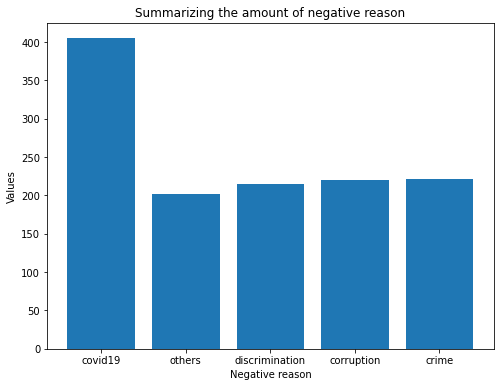

In [223]:
# Number of negative reason on whole data set include training and test
reason0 = neg_US_df.loc[neg_US_df['negative_reason'] == 0].shape[0]
reason1 = neg_US_df.loc[neg_US_df['negative_reason'] == 1].shape[0]
reason2 = neg_US_df.loc[neg_US_df['negative_reason'] == 2].shape[0]
reason3 = neg_US_df.loc[neg_US_df['negative_reason'] == 3].shape[0]
reason4 = neg_US_df.loc[neg_US_df['negative_reason'] == 4].shape[0]
fig = plt.figure(figsize=(8,6))
langs = ['covid19', 'others', 'discrimination', 'corruption', 'crime']  
reasons = [reason0, reason1, reason2, reason3, reason4]
plt.bar(langs,reasons)
plt.title('Summarizing the amount of negative reason')    
plt.xlabel('Negative reason')    
plt.ylabel('Values')
plt.show()

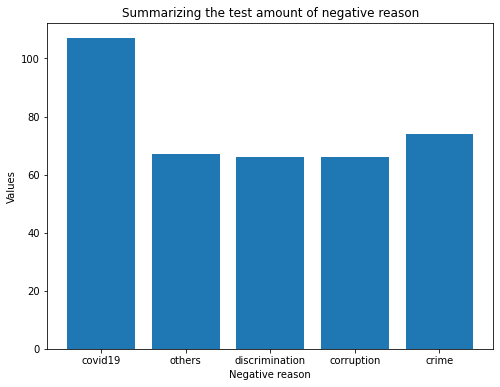

In [222]:
# Number of negative reason on test set
TfIdf_neg_test_df = pd.DataFrame(TfIdf_neg_x_test, columns=['TF-IDF Test X'])
TfIdf_neg_test_df['TF-IDF Test Y'] = np.array(TfIdf_neg_y_test)

reason0_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 0].shape[0]
reason1_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 1].shape[0]
reason2_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 2].shape[0]
reason3_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 3].shape[0]
reason4_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 4].shape[0]

fig = plt.figure(figsize=(8,6))
langs = ['covid19', 'others', 'discrimination', 'corruption', 'crime']  
reasons = [reason0_test, reason1_test, reason2_test, reason3_test, reason4_test]
plt.bar(langs,reasons)
plt.title('Summarizing the test amount of negative reason')    
plt.xlabel('Negative reason')    
plt.ylabel('Values')
plt.show()

In [197]:
# Number of negative reason on predictive
reason0_pred = (prediction_NBTfIdf_model_test == 0).sum()
reason1_pred = (prediction_NBTfIdf_model_test == 1).sum()
reason2_pred = (prediction_NBTfIdf_model_test == 2).sum()
reason3_pred = (prediction_NBTfIdf_model_test == 3).sum()
reason4_pred = (prediction_NBTfIdf_model_test == 4).sum()

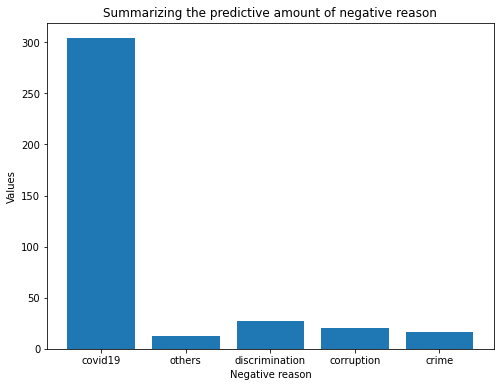

In [198]:
fig = plt.figure(figsize=(8,6))
langs = ['covid19', 'others', 'discrimination', 'corruption', 'crime']  
reasons = [reason0_pred, reason1_pred, reason2_pred, reason3_pred, reason4_pred]
plt.bar(langs,reasons)
plt.title('Summarizing the predictive amount of negative reason')    
plt.xlabel('Negative reason')    
plt.ylabel('Values')
plt.show()

## 5 Result

* Answer the research question stated above based on the outputs of your first model. 

* Describe the results of the analysis and discuss your interpretation of the results. 

* Explain how each party is viewed in the public eye based on the sentiment value. 

* For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets. 

* For both models, suggest one way you can improve the accuracy of your models.

#### 5.1 First Model Analysis

* The original data indicates that among 2552 tweets, 324 positive and 203 negative for Democratic Party, 330 positive and 415 negative for Republican Party. In all tweets, 49.9% tweets are associated with 2020 US election. Among the US data, 58.5% are talking about Republican Party and 41.5% are corresponding to Democratic Party. For Republican Party, 32.6% tweets are negative and 25.9% are positive. For Democratic Party, 16.0%% are negative and 25.5% are positive.

* Through training on the generic tweets, I choose a best performance model, logistic regression, among the 7 models to test at the 2020 US election data and predict for the sentiment. The predict result shows 44.7% are Republican Party negative, 13.9% are Republican Party positive; 24.4% are Democratic Party negative and 17.1% are Democratic Party positive. 

* The test accuracy is 0.7128 and the training accuracy at generic tweet is 0.9588, the test accuracy is much lower than training. It may because the generic tweet has 317251 word features due to the large amount of tweet in the dataframe, but 2020 US election data does not have that much word features. During the bag of words and TF-IDF, the US election data fit to the vectorizer of generic tweet word features and transfrom to itself, if the words in generic tweet not include in US election, a zero fill into the matrix. If the words in US election are not in the generic tweet, they will be ignored. So that lots of number in 2020 US election sparse matrix are zero, they carry less information. And some of the words in 2020 US election are dropped, so that the test accuracy is lower than training accuracy. 

* Although the prediction of amount of positive and negative sentiments are disparity with the true value. The prediction for Republican party has the same trend with the true sentiment, negative are more than positive. For Democratic party, the prediction value shows opposite trend that more negative sentiment than the positive, but the true situtation are positive more than negative. The amount of negative predictive result is always more than the actual amount, and the positive predictive result is always less than the actual result. Especially for Republican Party, it received a large amount of negative sentiment.

* From the 2020 US election result, Joe Biden got 306 electoral votes and Donald Trump got 232 electoral votes. From the NLP analytics based on tweet, it shows that more public get Trump negative sentiment on tweet and more positive to Biden, so that NLP analytics is useful for political parties during election campaigns.


#### 5.2 Second Model Analysis

* The training accuracy for Naive Bayes is the highest among the three models, but both of them are around 30%, which is due to cross validation. Each fold contain less training and validation data size, so that the training accuracy is quite low.

* Bayes’ Theorem provides a way that we can calculate the probability of a piece of data belonging to a given class, given our prior knowledge. MultinomialNB implements the naive Bayes algorithm for multinomially distributed data. It is one of the two classic naive Bayes variants used in text classification. 

* The test accuracy on the US negative data is 0.358, which is quite low. The reason is beacuse the imbalance data, above bar charts count the number of the negative reasons in the whole dataset, test set and prediction. In the whole dataset, nagetive reason 'Covid19' contains 30% among the five reasons. The negative reason in test set also has around 30% of 'Covid19'. So that during the test, more of the 'Covid19' will be predicted, which is proofed by the last plot. Over 80% of the negative reason are predicted as 'Covid19', it leads test accuracy becomes very low.

#### 5.3 Improve accuracy

* Model 1: The word features in the training set may not contain the keywords in 2020 US elections, the corpus in training set should consist of data from news sources e.g. recent tweets. This is because the vocabulary of a corpus varies with domains. Also, we can eliminating features with extremely low frequency,because the keywords in low occurance frequency in the corpus usually does not play a role in text classification. Reducing the feature can help to improve accuracy.

* Model 2: In order to fix the data imbalance, we can combine some closer reasons together to reduce the percentage of the main resaon among the reason pool. Also we can do classes reweight, it takes into account the asymmetry of cost errors directly during the classifier training, therefore the output probabilities for each class will already embed the cost error information. 